In [2]:
!pip3 install -U scikit-learn
!pip3 install torch torchvision torchaudio
!pip3 install pickle


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import pickle 

Unpacking the data

In [2]:
with open('../data/sampled_filters_train.pkl', 'rb') as f:
    data = pickle.load(f)


In [3]:
wavelengths = data['wavelengths']
spectra = data['spectra']
z = data['z']
X = data['X']
df_X = pd.DataFrame(X)
names=data['filter_names']
filter_wls = [int(name[1:-1].rstrip('W')) for name in names]
indices=[0,10,30,500,15000,800000]

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


define network

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diff // 2, (diff + 1) // 2))
        x = torch.cat([x2, x1], dim=1)

        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.convOut = nn.Conv1d(64, 1, kernel_size = 1)

        
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x4 = self.up1(x5, x4)
        x3 = self.up2(x4, x3)
        x2 = self.up3(x3, x2)
        x1 = self.up4(x2, x1)
        x = self.convOut(x1)
        return x


Add Noise

In [6]:
def add_noise(X, T):
    T += 1
    if T != 1:
        beta1, beta2 = 0.0001, 0.2
        beta_t = np.arange(beta1, beta2 + 0.0001, (beta2 - beta1)/(T - 1) )
    else: 
        beta_t = [0.0001]
    alpha = [1-beta_t[t] for t in range(len(beta_t))]
    alpha_bar = np.prod(alpha[:T-1])

    mu, sigma = math.sqrt(alpha_bar) * X, (1 - alpha_bar) * np.identity(len(X))
    X_tm1 = np.random.multivariate_normal(mu, sigma)
    mu, sigma = math.sqrt(1 - beta_t[T-1]) * X_tm1, (beta_t[T-1]) * np.identity(len(X_tm1))
    X_t = np.random.multivariate_normal(mu, sigma)
    return list(X_t), list(X_tm1)

def gen_dataset(data):
    dataset = {
        "X_t": [],
        "X_tm1": []
    }

    for d in data:
        T = random.randint(1, 100)
        X_t, X_tm1 = add_noise(d, T)
        dataset["X_t"].append(X_t)
        dataset["X_tm1"].append(X_tm1)
    dataset["X_t"] = np.array(dataset["X_t"])
    dataset["X_tm1"] = np.array(dataset["X_tm1"]) 
    return dataset

class MyDataset(Dataset):
    def __init__(self, data_dict):
        self.data_dict = data_dict
        self.keys = list(data_dict.keys())
        self.length = len(data_dict[self.keys[0]])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        data = {key: self.data_dict[key][index] for key in self.keys}
        return data

Define model

In [7]:
model = UNet().double().to(device)
model.parameters()

<generator object Module.parameters at 0x00000283BE1D3D80>

Training

In [8]:
#loss
loss_fn = nn.MSELoss()
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        X_t, X_tm1 = data.values()
        X_t = X_t.unsqueeze(1).double().to(device)
        X_tm1 = X_tm1.unsqueeze(1).double().to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(X_t)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, X_tm1)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [9]:
n = 64000
scaler = StandardScaler()
X_normalized = np.array([list(scaler.fit_transform(torch.tensor(X[i]).reshape(-1, 1)).reshape(1, -1)) for i in range(n)]).squeeze()
dataset = MyDataset(gen_dataset(X_normalized[0:n]))

train_dataloader = DataLoader(dataset, batch_size=16, shuffle=False)


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer{}'.format(timestamp))
epoch_number = 0

EPOCHS = 1


for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    
    print('LOSS train: ', avg_loss)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training',{ 'Training' : avg_loss}, epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 0.2670146323363244
  batch 200 loss: 0.2058492579416161
  batch 300 loss: 0.20718201151640195
  batch 400 loss: 0.2049605401905011
  batch 500 loss: 0.20384382897491948
  batch 600 loss: 0.20331311073834002
  batch 700 loss: 0.20014045557055557
  batch 800 loss: 0.20224794856240128
  batch 900 loss: 0.19976191223848563
  batch 1000 loss: 0.20273894946918156
  batch 1100 loss: 0.20299059053808036
  batch 1200 loss: 0.2034532277402562
  batch 1300 loss: 0.20094106491180008
  batch 1400 loss: 0.20159514355247854
  batch 1500 loss: 0.2010680313616975
  batch 1600 loss: 0.2012831811949683
  batch 1700 loss: 0.1998558787728571
  batch 1800 loss: 0.19923371758438782
  batch 1900 loss: 0.1986414864731357
  batch 2000 loss: 0.20195957501535441
  batch 2100 loss: 0.20130333576668893
  batch 2200 loss: 0.20095358716714998
  batch 2300 loss: 0.19822593561339605
  batch 2400 loss: 0.20034288257245506
  batch 2500 loss: 0.200942640334181
  batch 2600 loss: 0.19851678167488

In [48]:
%load_ext tensorboard
%tensorboard --logdir /logs

Print output of model

T =  121    --   datasample =  809
true loss:  tensor(0.1721, dtype=torch.float64)
loss from model:  tensor(0.1717, dtype=torch.float64)


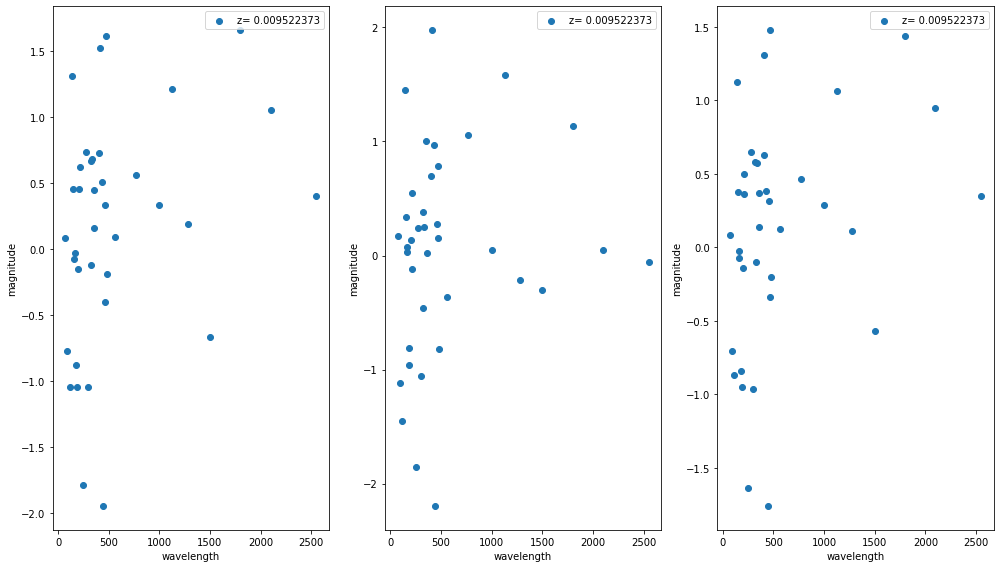

In [41]:
p1 = random.randint(0, 1000)
T1 = random.randint(0, 1000)
print("T = ", T1, "   --   datasample = ", p1)
X_t, X_tm1 = add_noise(X_normalized[p1], T1)
X_t = torch.tensor(X_t).unsqueeze(0).unsqueeze(0)
X_tm1 = torch.tensor(X_tm1).unsqueeze(0).unsqueeze(0)
pred = model(X_t.to(device)).cpu().detach()
loss1 = loss_fn(X_t, X_tm1)
loss2 = loss_fn(pred, X_tm1)
print("true loss: ", loss1)
print("loss from model: ", loss2)

plt.figure(figsize= (14, 8))

plt.subplot(1, 3, 1)
plt.scatter(filter_wls, X_t, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(filter_wls, X_tm1, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(filter_wls, pred, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()


plt.tight_layout()
plt.show()


In [47]:
def denoise(X, T = 100):
    X = torch.tensor(X).unsqueeze(0).unsqueeze(0).to(device)
    for _ in range(T):
        X = model(X) 
    return X

mu, sigma = np.zeros(37), np.identity(37)
X_t = np.random.multivariate_normal(mu, sigma)
X_t_denoise = denoise(X_t).cpu().detach()

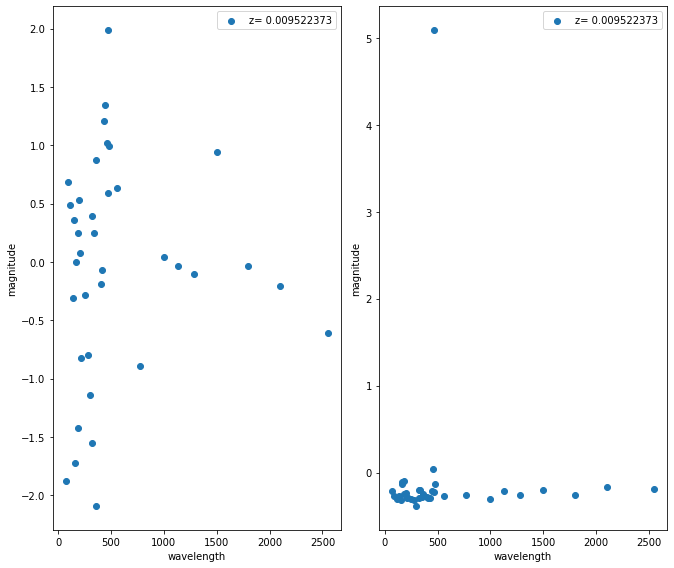

In [48]:
#p1 = random.randint(0, 1000)
#p1 = 625
#T1 = random.randint(0, 1000)
#T1 = 665



plt.figure(figsize= (14, 8))

plt.subplot(1, 3, 1)
plt.scatter(filter_wls, X_t, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(filter_wls, X_t_denoise, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.tight_layout()
plt.show()


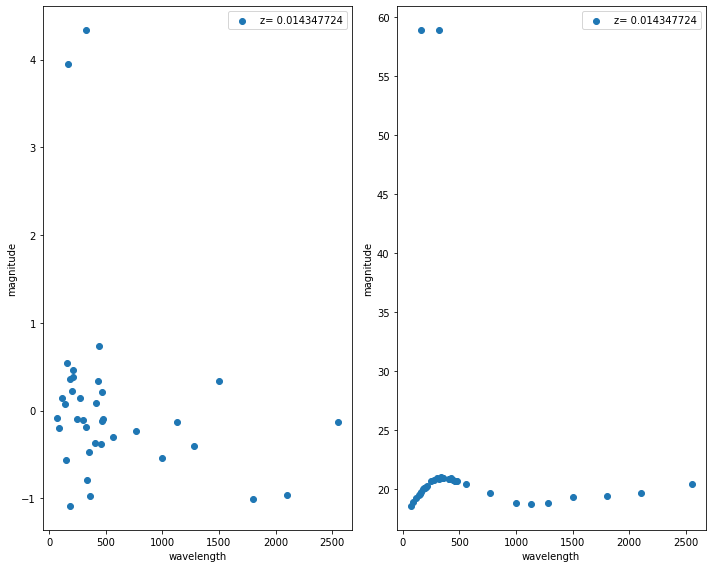

In [88]:
plt.figure(figsize= (10, 8))

plt.subplot(1, 2, 2)
plt.scatter(filter_wls, X[4], label = "z= "+str(z[0,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 2, 1)
plt.scatter(filter_wls, add_noise(X_normalized[4], T = 2), label = "z= "+str(z[0,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()



plt.tight_layout()
plt.show()


In [49]:
X[0]

array([20.786884, 20.960768, 21.265028, 21.509062, 21.601727, 21.808668,
       58.9     , 21.899237, 21.870485, 22.042837, 22.1664  , 22.201782,
       22.337282, 22.382853, 22.393621, 22.491522, 22.391426, 22.527351,
       22.557444, 22.61449 , 22.445515, 22.539598, 22.658358, 22.670202,
       22.752363, 58.9     , 58.9     , 22.814674, 22.803913, 23.091652,
       23.25525 , 23.325388, 23.654198, 24.586325, 24.331484, 25.391253,
       25.81203 ], dtype=float32)

In [50]:
X0

array([18.18387858, 19.11158712, 18.77033567, 18.73173945, 19.83147745,
       19.76799058, 52.53073971, 19.24033204, 19.82485043, 19.58854701,
       19.18816197, 20.34733135, 19.80594306, 20.61285027, 20.00532452,
       19.72817818, 20.04521396, 20.65350765, 20.20638097, 19.88978372,
       20.32575284, 19.93396853, 20.56848211, 20.20734979, 20.52066788,
       52.92152031, 52.14634073, 20.77923495, 20.89681471, 21.11384064,
       21.1684129 , 21.25573751, 21.35002085, 21.63235812, 22.5197138 ,
       22.67553267, 23.9491519 ])